# Find the perfect place to stay in Texas!

## Search Engine

### Conjunctive query

In [1]:
import numpy as np
import pandas as pd
import csv
import nltk
import string
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

**Data Cleaning Function**

In [2]:
def string_cleaning(string_raw):

    #replace $ with dollar
    m = re.sub('[$]','dollar',string_raw)
    # replace new line symbols with whitespace
    m = m.replace('\\r', ' ').replace('\\n', ' ')
    #remove punctuations with 2 ways
    #m = ''.join([c for c in m if c not in string.punctuation])
    m = re.sub('[%s]' % re.escape(string.punctuation), ' ', m)
    # seperate numbers from words
    m = re.sub(r'(?<=[\d+])(?=[a-zA-Z_])', r' ', m)
    # remove digits from messages
    #m = ''.join(c for c in m if not c.isdigit())
    m = nltk.tokenize.word_tokenize(m)
    #remove stopwords
    m = [word for word in m if word.lower() not in stopwords.words('english')]
    #stemming of words
    sno = nltk.stem.SnowballStemmer('english')
    string_new = [sno.stem(word) for word in m]
    
    return string_new

In [3]:
import os

path, dirs, files = next(os.walk("directory"))
file_count = len(files)

### Creating a full corpus of with all the words appeared in the descriptions and the titles

In [ ]:
corpus = []
for i in range(file_count):
    filename = 'directory/doc_{}.tsv'.format(i+1)
    with open(filename) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        document = []
        for row in reader:
            document.append(row)
        corpus.append(document[4][0] + document[7][0])

In [ ]:
#data cleaning of the corpus and tokenization
lista = []
for i in range(len(corpus)):
    lista.append(string_cleaning(corpus[i]))
    
#flatten the list for every word occurence
lista_flatten = [y for x in lista for y in x]final_dict = {str(i+1):x for i,x in enumerate(c)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(c)}

In [ ]:
#create a dictionary with all the words counts sorted by frequency
from collections import Counter
c = Counter(lista_flatten)
c= dict(c.most_common())

final_dict = {str(i+1):x for i,x in enumerate(c)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(c)}

### Index  and Inverse Index dictionary with all the words appeared in each document

In [ ]:
indx = {}
for n,document in enumerate(lista):
    new_document = []
    for word in document:
        new_document.append(final_dict_inv[str(word)])
    indx[str(n+1)] = new_document 
    
inv_indx = {str(i):[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i in range(len(indx)):
        if int(word) in indx[str(i+1)]:
            inv_indx[word].append(i+1)    

#### Save and Load of the dictionary for future usage

In [ ]:
import json

with open('regular_index.json', 'w') as fp:
    json.dump(indx, fp)

with open('inverted_index.json', 'w') as fp:
    json.dump(inv_indx, fp)
    
with open('words_transformation.json', 'w') as fp:
    json.dump(final_dict, fp)    
    
with open('words_inverse_transformation.json', 'w') as fp:
    json.dump(final_dict_inv, fp) 
    

In [4]:
import json

with open('regular_index.json', encoding='utf-8') as fp:
    indx = json.loads(fp.read())

with open('inverted_index.json', encoding='utf-8') as fp:
    inv_indx = json.loads(fp.read())

with open('words_transformation.json', encoding='utf-8') as fp:
    final_dict = json.loads(fp.read())

with open('words_inverse_transformation.json', encoding='utf-8') as fp:
    final_dict_inv = json.loads(fp.read())

## Example Query Executing

In [5]:
query = 'beautiful house in San Antonio'

In [6]:
# query cleaning and tokenization

q = string_cleaning(query)

q_new = sorted([final_dict_inv[str(element)] for element in q if element in list(final_dict.values())])[::-1] ##sorted to less_frequent to most
#finding documents containing all terms
documents = [inv_indx[str(term)] for term in q_new]
documents_final = set(documents[0])
for l2 in documents[1:]:
    documents_final = documents_final.intersection(set(l2))

In [7]:
#dataframe presantation of the output

cols=['Title','Description','City','Url']
df = pd.DataFrame([])
for i in documents_final:
    filename = 'directory/doc_{}.tsv'.format(i)
#[7,4,2,8] taking only the elements that I was=nt to show to the user --> ['Title','Description','City','Url']
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T.loc[:,[7,4,2,8]],ignore_index=True)
df.columns = cols
df.index = list(range(1,len(documents_final)+1))

df.head(15)

,Title,Description,City,Url
1,Cute two story house in San Antonio,Really nice quiet neighborhood in beautiful Sa...,San Antonio,https://www.airbnb.com/rooms/11166341?location...
2,"Charming Columbus, Tx Guest Quarters","My place is great for work or corporate stays,...",Columbus,https://www.airbnb.com/rooms/18269171?location...
3,Sandra's Cottage w/Pool (Centrally Located!),"Beautifully decorated cottage. Quaint, cozy, a...",San Antonio,https://www.airbnb.com/rooms/13299372?location...
4,Gorgeous Eclectic House.,Our charming home with vintage and contemporar...,San Antonio,https://www.airbnb.com/rooms/18396644?location...
5,A Cozy Home with a Beautiful Nature Views,"This home is on the North Side of San Antonio,...",San Antonio,https://www.airbnb.com/rooms/19190311?location...
6,Spacious 2-story Family Home close to everything!,This beautiful spacious home is perfect for yo...,New Braunfels,https://www.airbnb.com/rooms/19586812?location...
7,"Beautiful 5BR House Dona Ana Cove, San Antonio...",Key in your travel dates to find out if qualif...,Helotes,https://www.airbnb.com/rooms/12954474?location...
8,Priv. Room@Beautiful House by La Cantera/Six F...,"- Stay in an Beautiful, relaxing house with gr...",San Antonio,https://www.airbnb.com/rooms/8557583?location=...
9,Riverfront Retreat,Our retreat is close to Blanco State Park and ...,Blanco,https://www.airbnb.com/rooms/13528589?location...
10,"Charming Columbus, Tx Guest Quarters","My place is great for work or corporate stays,...",Columbus,https://www.airbnb.com/rooms/18269171?location...


## Conjunctive query & Ranking score (Cosine Similarity)

### Cosine Index  and Inverse Cosine Index dictionary with all the words appeared in each documen

In [ ]:
from math import log
inv_indx_cosine = {i:[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i,l in enumerate(list(indx.values())):
        if int(word) in l:
            tf = l.count(int(word))/len(l)
            id_f = log(file_count/len(inv_indx[word]))
            inv_indx_cosine[word].append((i+1,tf*id_f))
            
indx_cosine = {}
for doc in range(file_count):
    indx_cosine[str(doc+1)] = []
    for term in list(final_dict.keys()):
        if int(doc+1) in [r for r in inv_indx[str(term)]]:
            k  = inv_indx[term].index(doc+1)
            indx_cosine[str(doc+1)].append((term,inv_indx_cosine[term][k][1]))

#### Save and Load for future usage

In [ ]:
with open('inverted_index_cosine.json', 'w') as fp:
    json.dump(inv_indx_cosine, fp)
    
with open('index_cosine.json', 'w') as fp:
    json.dump(indx_cosine, fp)   

In [8]:
with open('inverted_index_cosine.json', encoding='utf-8') as fp:
    inv_indx_cosine = json.loads(fp.read())

with open('index_cosine.json', encoding='utf-8') as fp:
    indx_cosine = json.loads(fp.read())

## Example Query Executing

In [12]:
query = 'beautiful house in San Antonio'

q = string_cleaning(query)

#query cleaning and tokenization
q_new = Counter([final_dict_inv[str(element)] for element in q if element in list(final_dict.values())])
#finding documents containing all terms
documents = [inv_indx[str(term)] for term in q_new]
documents_final = set(documents[0])
for l2 in documents[1:]:
    documents_final = documents_final.intersection(set(l2))

In [13]:
#pushing results into a heap and finding top-k documents

from heapq import heappush, heappop
from math import sqrt
similarity = []
for doc in documents_final:
    s = 0
    for term in list(q_new.keys()):
# in order to compute the inner product between the documents and the query in which the terms of the query exists
        if doc in inv_indx[str(term)]:  
            k  = inv_indx[str(term)].index(doc)
            s += inv_indx_cosine[str(term)][k][1]*(q_new[term]/len(q_new))
            #s += inv_indx_cosine[term][k][1]*(q_new[term])
    qm = sqrt(sum([k/len(q_new)**2 for k in q_new.values()]))
    #qm = sqrt(sum([k**2 for k in q_new.values()]))  ## compute without dividing with the length of the query
    dm = sqrt(sum([k[1]**2 for k in indx_cosine[str(doc)]]))
    #similarity.append((doc,s/(sqrt(qm)*sqrt(dm))))  ## ------------//-----------//-----------//--------
    heappush(similarity,(s/(sqrt(qm)*sqrt(dm)),doc))

#keeping only top-k documents
k = 100
for i in range(len(similarity)-k):
    heappop(similarity)    

### Output

In [14]:
# sorting of the documents according the similarity with the query
similarity = sorted(similarity)[::-1]
cols=['Title','Description','City','Url']
df = pd.DataFrame([])
docs = [k[1] for k in similarity]
for i in range(len(docs)):
    filename = 'directory/doc_{}.tsv'.format(docs[i])
    #[7,4,2,8] taking only the elements that I was=nt to show to the user --> ['Title','Description','City','Url']
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T.loc[:,[7,4,2,8]],ignore_index=True)
#df['Similarity']. = similarity[i][0]
df.columns = cols
df['Similarity'] = [k[0] for k in similarity]
df.index = list(range(1,len(df)+1))
df

,Title,Description,City,Url,Similarity
1,Cute two story house in San Antonio,Really nice quiet neighborhood in beautiful Sa...,San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.214126
2,Cute two story house in San Antonio,Really nice quiet neighborhood in beautiful Sa...,San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.214126
3,San Antonio Lake House on Lake LBJ,The San Antonio Lake House is located in the T...,Kingsland,https://www.airbnb.com/rooms/13634952?location...,0.201379
4,San Antonio Lake House on Lake LBJ,The San Antonio Lake House is located in the T...,Kingsland,https://www.airbnb.com/rooms/13634952?location...,0.201379
5,House Nestled in Quiet Neighborhood,I hope you’ll love my place because of the qui...,San Antonio,https://www.airbnb.com/rooms/18568735?location...,0.185773
6,House Nestled in Quiet Neighborhood,I hope you’ll love my place because of the qui...,San Antonio,https://www.airbnb.com/rooms/18568735?location...,0.185773
7,A Cozy Home with a Beautiful Nature Views,"This home is on the North Side of San Antonio,...",San Antonio,https://www.airbnb.com/rooms/19190311?location...,0.160501
8,Blanco River House,River House is just off the square in quaint B...,Blanco,https://www.airbnb.com/rooms/7159265?location=...,0.158954
9,Priv. Room@Beautiful House by La Cantera/Six F...,"- Stay in an Beautiful, relaxing house with gr...",San Antonio,https://www.airbnb.com/rooms/8557583?location=...,0.136170
10,Private room in cozy house.,Come and visit or stay longer here in beautifu...,San Antonio,https://www.airbnb.com/rooms/16507221?location...,0.129963


## Define a new score!

In [15]:
#create a dataframe appending all the documents in the database
cols=['Average_rate_per_night','Bedrooms_count','City','Date_of_listing','Description','Latitude','Longitude','Title','Url']
df = pd.DataFrame([])
for i in range(file_count):
    filename = 'directory/doc_{}.tsv'.format(i+1)
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols

#dictionary with most of Texas cities and their coordinates
all_cities = pd.read_csv('uscitiesv1.4.csv')
texas = all_cities[all_cities.state_name=='Texas']

cities_cord = {}
for city in df.City.unique():
    if city in texas.city.values:
        cities_cord[city] = [texas[texas.city == city].lat.iloc[0],texas[texas.city == city].lng.iloc[0]]
        
df.dropna(inplace=True)
lat = df.Latitude.apply(pd.to_numeric,errors='coerce').values
long = df.Longitude.apply(pd.to_numeric,errors='coerce').values
X = [[l1,l2] for l1,l2 in zip(lat,long)]

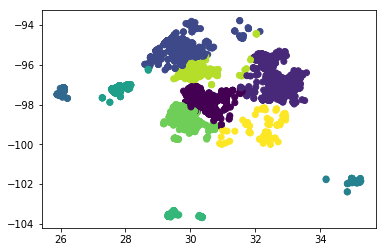

In [16]:
#creating a KMEANS clustering in order to cluster closest cities together in 10 main clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10).fit(X)

#clustering visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(lat,long,c=kmeans.labels_)

## Example query execution

In [17]:
query = 'beautiful house in San Antonio'
qprice = 60  #query average_price
qrooms = 2 #query average # of rooms
qarea = 'San Antonio' #query area

if qarea in cities_cord.keys():  # find city coordinates through dictionary or geolocator library
    la,lo = cities_cord[qarea]
else:
    from geopy.geocoders import Nominatim
    geolocator = Nominatim()
    la,lo = geolocator.geocode(qarea + " US")[-1]
qarea = kmeans.predict([[la,lo]])[0]+1  #clusterize area
q_values = [qprice/150,qrooms/10,qarea/10,la/30,lo/100]  #normalize query values to a max value

#query cleaning
q = string_cleaning(query)
q_new = sorted([final_dict_inv[str(element)] for element in q if element in list(final_dict.values())])[::-1] ##sorted to less_frequent to most
#find each document containing all the terms
documents = [inv_indx[str(term)] for term in q_new]
documents_final = set(documents[0])
for l2 in documents[1:]:
    documents_final = documents_final.intersection(set(l2))


## Finding Results

In [35]:
#Loading Documents containing each term
df = pd.DataFrame([])
for i in documents_final:
    filename = 'directory/doc_{}.tsv'.format(i)
    #[7,4,2,8] taking only the elements that I was=nt to show to the user --> ['Title','Description','City','Url']
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols
df.index = list(range(1,len(documents_final)+1))
#Replace Studio Bedrooms with # 1
df.Bedrooms_count.replace('Studio',1,inplace=True)

#Columns cleaning and numerization
price = df.Average_rate_per_night.str.split('$').str[-1].apply(pd.to_numeric).values
rooms = df.Bedrooms_count.apply(pd.to_numeric,errors='coerce').values
lat = df.Latitude.apply(pd.to_numeric,errors='coerce').values
long = df.Longitude.apply(pd.to_numeric,errors='coerce').values
lat = np.nan_to_num(lat)
long = np.nan_to_num(long)
X = [[l1,l2] for l1,l2 in zip(lat,long)]
cities = [kmeans.predict(X)][0]+1  #City Clustering

#Final Matrix for each document in order to apply chi-square statistics to each row of it
matrix = np.array([price/150,rooms/10,cities/10,lat/30,long/100]).T
matrix

array([[ 0.86666667,  0.3       ,  0.8       ,  0.98588211, -0.98381229],
       [ 1.33333333,  0.3       ,  0.9       ,  0.99034007, -0.96539676],
       [ 0.67333333,  0.1       ,  0.8       ,  0.98902128, -0.98658216],
       [ 0.56666667,  0.3       ,  0.8       ,  0.98174469, -0.98510782],
       [ 0.73333333,  0.1       ,  0.8       ,  0.98896771, -0.98418352],
       [ 1.54666667,  0.3       ,  0.8       ,  0.98919173, -0.9813502 ],
       [ 2.79333333,  0.5       ,  0.8       ,  0.98616125, -0.98660127],
       [ 0.3       ,  0.1       ,  0.8       ,  0.98707973, -0.98616689],
       [ 2.5       ,  0.3       ,  0.8       ,  1.00312822, -0.98410653],
       [ 1.33333333,  0.3       ,  0.9       ,  0.99034007, -0.96539676],
       [ 1.83333333,  0.3       ,  0.1       ,  1.01881093, -0.98281663],
       [ 0.43333333,  0.2       ,  0.8       ,  0.98217756, -0.98353234],
       [ 2.89333333,  0.2       ,  0.1       ,  1.02179612, -0.98433686],
       [ 0.24666667,  0.1       ,  0.8

#### Apply chi-square statistics test and heappushing of the data

In [82]:
from scipy.stats import chisquare
from heapq import heappush, heappop
score = []
for i in range(matrix.shape[0]):
    heappush(score,(chisquare(q_values,f_exp=matrix[i])[-1],list(documents_final)[i]))  
    
#keeping only top-k documents
k = 100
score = sorted(score)[::-1]
for i in range(len(score)-k):
    heappop(score)
    
#Output
df = pd.DataFrame([])
score = sorted(score)[::-1]
docs = [k[1] for k in score]
for i in range(len(docs)):
    filename = 'directory/doc_{}.tsv'.format(docs[i])
    #[7,4,2,8] taking only the elements that I was=nt to show to the user --> ['Title','Description','City','Url']
    df = df.append(pd.read_csv(filename,sep='\t',header=None).T,ignore_index=True)
df.columns = cols
df['Ranking'] = [k[0] for k in score]
df['Latitude'] = df['Latitude'].astype('float64')
df['Longitude'] = df['Longitude'].astype('float64')
#df['Average_rate_per_night'] = df.Average_rate_per_night.str.split('$').str[-1].apply(pd.to_numeric).values
#df.rename(columns={"Average_rate_per_night": "Average_price_per_night ($)"},inplace=True)
df.index = list(range(1,len(df)+1))
df

,Average_rate_per_night,Bedrooms_count,City,Date_of_listing,Description,Latitude,Longitude,Title,Url,Ranking
1,$65,2,San Antonio,July 2015,I hope you’ll love my place because of the qui...,29.465327,-98.353234,House Nestled in Quiet Neighborhood,https://www.airbnb.com/rooms/18568735?location...,0.999999
2,$65,2,San Antonio,July 2015,I hope you’ll love my place because of the qui...,29.465327,-98.353234,House Nestled in Quiet Neighborhood,https://www.airbnb.com/rooms/18568735?location...,0.999999
3,$85,3,San Antonio,March 2017,Our charming home with vintage and contemporar...,29.452341,-98.510782,Gorgeous Eclectic House.,https://www.airbnb.com/rooms/18396644?location...,0.999175
4,$85,3,San Antonio,March 2017,Our charming home with vintage and contemporar...,29.452341,-98.510782,Gorgeous Eclectic House.,https://www.airbnb.com/rooms/18396644?location...,0.999175
5,$45,1,San Antonio,April 2015,"- Stay in an Beautiful, relaxing house with gr...",29.612392,-98.616689,Priv. Room@Beautiful House by La Cantera/Six F...,https://www.airbnb.com/rooms/8557583?location=...,0.997873
6,$37,1,San Antonio,December 2016,Come and visit or stay longer here in beautifu...,29.502868,-98.650763,Private room in cozy house.,https://www.airbnb.com/rooms/16507221?location...,0.995531
7,$101,1,San Antonio,June 2016,"Beautifully decorated cottage. Quaint, cozy, a...",29.670638,-98.658216,Sandra's Cottage w/Pool (Centrally Located!),https://www.airbnb.com/rooms/13299372?location...,0.994811
8,$110,1,San Antonio,June 2017,"This home is on the North Side of San Antonio,...",29.669031,-98.418352,A Cozy Home with a Beautiful Nature Views,https://www.airbnb.com/rooms/19190311?location...,0.992723
9,$130,3,San Antonio,October 2011,Really nice quiet neighborhood in beautiful Sa...,29.576463,-98.381229,Cute two story house in San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.990785
10,$130,3,San Antonio,October 2011,Really nice quiet neighborhood in beautiful Sa...,29.576463,-98.381229,Cute two story house in San Antonio,https://www.airbnb.com/rooms/11166341?location...,0.990785


## Bonus Step: Make a nice visualization!

In [76]:
df['Latitude'] = df['Latitude'].astype('float64')
df['Longitude'] = df['Longitude'].astype('float64')

la,lo = ((29.4722, -98.5247)) #some random latitude and longititude coordinates of user
pos = [] # list that will contain all the lats and longs of df
#for lat, long in df.itertuples(index=False):
for lat, long in zip(df.Latitude, df.Longitude): 
    tmp = [] # temporary list containing lat and long for each city
    tmp.append(lat)
    tmp.append(long)
    pos.append(tmp) # appending tmp list to the main list
# radius amount (in km)
dist = 50

In [78]:
import folium as fl
from geopy import distance

# creating map m with location at latitude la and longitude lo, as we defined earlier
m = fl.Map(location=[la, lo], zoom_start=12)
tooltip = df.Url
# loop on all the position of df
for n,loc in enumerate(pos):
    dis = distance.distance([la, lo], loc).km # calculating distance between 'our' location and each location in df
    fl.Marker([la, lo], icon=fl.Icon(color='red')).add_to(m) # placing our position on map m (red color)
    if dis <= dist: # if distance is less or equal to max radius
        fl.Marker(loc, tooltip=df['Average_rate_per_night'][n+1]).add_to(m) # placing marker of each house in the df with distance less or equal to dist

# creating the radius on the map
fl.Circle(
    location=[la, lo],
    radius=dist*1000, # must be multiplied because is in meters
    fill=True,
    fill_color='#3186cc'
).add_to(m)
m